# larger datasets

In [1]:
import numpy as np
import os, sys
import json

project_root = os.path.abspath("")  # alternative
if project_root[-12:] == 'LyoSavin2023':
    base_dir = project_root
else:
    base_dir = os.path.dirname(project_root)
sys.path.append(os.path.join(base_dir, 'core'))
sys.path.append(os.path.join(base_dir, 'core/utils'))

import torch
import torch.optim as optim
import time
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import zarr

from utils import remove_all_ticks_and_labels

# import MNIST dataset

In [3]:
# params
description = {
    'model_name': 'dendritic-mnist',
    'model_number': 8,
    'num_steps': 100,
    'forward_schedule': 'sine',
    'batch_size': 128,
    'hidden_cfg': [5, 5, 5, 5],
    'num_ambient_dims': 28 * 28,
    'num_epochs': 100,
    'manifold_type': 'mnist',
    'lr': 3e-4,
    'optimizer': 'Adam',
    'classes': 'all',
}

# # params
# description = {
#     'model_name': 'fc-mnist',
#     'model_number': 7,
#     'num_hidden_layers': 8,
#     'num_steps': 100,
#     'forward_schedule': 'sine',
#     'batch_size': 128,
#     'hidden_cfg': 1024,
#     'num_ambient_dims': 28 * 28,
#     'num_epochs': 400,
#     'manifold_type': 'mnist',
#     'lr': 3e-3,
#     'optimizer': 'Adam',
#     'classes': [0, 1, 2],
# }


pretrained = False
if pretrained:
    description['pretrained'] = True
    description['pretrained_model_name'] = 'dendritic-mnist'
    description['pretrained_model_num'] = 6
else:
    description['pretrained'] = False
    
# save description
with open(os.path.join(base_dir, 'core', 'model_description', f'{description["model_name"]}_{description["model_number"]}.json'), 'w') as f:
    json.dump(description, f)

In [7]:
import torch
from torchvision import datasets, transforms
mnist_dir = os.path.join(base_dir, 'core', 'datasets', 'mnist')

mnist_train = datasets.MNIST(mnist_dir, train=True, download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    # transforms.Normalize((0.1307,), (0.3081,))
                ]))

print(torch.min(mnist_train.data), torch.max(mnist_train.data))
print(mnist_train[0][0].min(), mnist_train[0][0].max())
from image_utils import rescale_to_neg_one_to_one
test = rescale_to_neg_one_to_one(mnist_train[0][0])
print(test.min(), test.max())

# ------------------------------- select digits ------------------------------ #
# indices = (mnist_train.targets == 0) | (mnist_train.targets == 1) | (mnist_train.targets == 2)
# mnist_train.data, mnist_train.targets = mnist_train.data[indices], mnist_train.targets[indices]

train_loader = torch.utils.data.DataLoader(
    mnist_train,
    batch_size=description['batch_size'], shuffle=True)

# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST(mnist_dir, train=False, transform=transforms.Compose([
#                        transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,))
#                    ])),
#     batch_size=args['test_batch_size'], shuffle=True, **kwargs)

tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
tensor(0.) tensor(1.)
tensor(-1.) tensor(1.)


torch.Size([1000, 784])
torch.Size([784000])


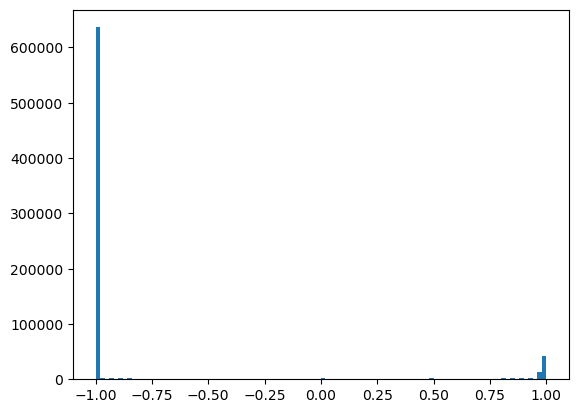

In [10]:
# how is the data distributed?
all_pixels = []
for i in range(1000):
    all_pixels.append(mnist_train[i][0].squeeze().reshape(-1))
all_pixels = torch.stack(all_pixels)
print(all_pixels.shape)
all_pixels = rescale_to_neg_one_to_one(all_pixels)

all_pixels = all_pixels.reshape(-1)
print(all_pixels.shape)

fig, ax = plt.subplots(1, 1)
a = ax.hist(all_pixels, bins=100)

torch.Size([1, 28, 28])
torch.Size([28, 28])
tensor(-3.0263)
tensor(3.0407)
torch.Size([15680])


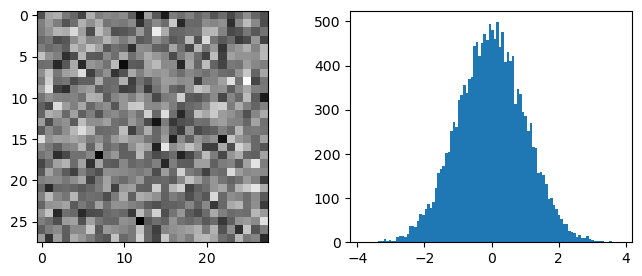

In [20]:
# forward process
from image_utils import generate_noisy_sample

num_steps = 100
t = 99
x_0 = mnist_train[0][0]
print(x_0.shape)
x_0s = []
for i in range(20):
    x_0s.append(mnist_train[i][0])
x_0s = torch.stack(x_0s)

schedule = 'sine'
start = 1e-5
end = 1.
x_noisy = generate_noisy_sample(num_steps, t, x_0, schedule, start, end)[0]

print(x_noisy.shape)
print(x_noisy.min())
print(x_noisy.max())

fig, ax = plt.subplots(1,2, figsize=(8, 3))
ax[0].imshow(x_noisy, cmap='gray')

# get distribution of pixels 
x_noisys = []
for i in range(20):
    x_noisys.append(generate_noisy_sample(num_steps, t, x_0s[i], schedule, start, end)[0])
x_noisys = torch.stack(x_noisys)
x_noisys = x_noisys.reshape(-1)
print(x_noisys.shape)
a = ax[1].hist(x_noisys, bins=100)


In [29]:
def train(num_epochs, model, train_loader, num_steps, optimizer, tb, device):
    from torch.autograd import Variable
    from image_utils import calculate_loss
    
    for epoch in tqdm(range(1, int(num_epochs) + 1)):
        # start training    
        for batch_idx, (data, target) in enumerate(train_loader):
            
            # data, target = data.to(device), target.to(device)
            data = data.to(device)
            # data, target = Variable(data), Variable(target)
            
            # compute the loss
            # loss = calculate_loss(model, data, num_steps, alphas_bar_sqrt, one_minus_alphas_prod_sqrt, device, norm='l2', has_class_label=False)
            loss = calculate_loss(model, data, n_steps=description['num_steps'], forward_schedule=description['forward_schedule'], norm='l2', device=device)
            
            # zero the gradients
            optimizer.zero_grad()
            # backward pass: compute the gradient of the loss wrt the parameters
            loss.backward()
            # call the step function to update the parameters
            optimizer.step()
            
            # write to tensorboard
            tb.add_scalar('Loss', loss.item(), epoch+batch_idx)
        
    return model

In [22]:
global device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}', flush=True)

from models import VariableDendriticCircuit, FullyConnectedNetwork
model = VariableDendriticCircuit(hidden_cfg=description['hidden_cfg'], 
                                num_in=description['num_ambient_dims'], 
                                num_out=description['num_ambient_dims'], 
                                bias=True)

# model = FullyConnectedNetwork(n_dim_data=description['num_ambient_dims'], num_hidden=description['hidden_cfg'], num_hidden_layers=description['num_hidden_layers'])
model = model.to(device)
if description['pretrained']==True:
    from utils import load_model_weights
    pretrained_model_name = description['pretrained_model_name']
    pretrained_model_num = description['pretrained_model_num']
    print(f'taking weights from pretrained model {pretrained_model_name}_{pretrained_model_num}!')
    model = load_model_weights(model, pretrained_model_name, pretrained_model_num, device)


optimizer = optim.Adam(model.parameters(), lr=description['lr'])
# optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])


Using device: cuda


In [30]:
run_dir = os.path.join(base_dir, 'demos/runs', f'{description["model_name"]}_{description["model_number"]}')
tb = SummaryWriter(run_dir, flush_secs=1)

start_time = time.time()

model.train()
model = train(description['num_epochs'], model, train_loader, description['num_steps'], optimizer, tb, device)

from utils import save_model_weights
save_model_weights(model, description['model_name'], description['model_number'])
tb.flush()

  0%|          | 0/100 [00:00<?, ?it/s]

model state dict saved in directory: /mnt/ceph/users/blyo1/projects/LyoSavin2023/core/saved_weights/dendritic-mnist_7.pt


# load model

In [31]:
model_name = 'dendritic-mnist'
model_num = 7

desc_dir = os.path.join(base_dir, 'core', 'model_description', f'{model_name}_{model_num}.json')
# load json file form desc_dir
with open(desc_dir, 'r') as f:
    description = json.load(f)

In [22]:
# load model weights
from models import VariableDendriticCircuit, FullyConnectedNetwork
global device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}', flush=True)

# model = FullyConnectedNetwork(n_dim_data=description['num_ambient_dims'], num_hidden=description['hidden_cfg'], num_hidden_layers=description['num_hidden_layers'])
model = VariableDendriticCircuit(hidden_cfg=description['hidden_cfg'], 
                                num_in=description['num_ambient_dims'], 
                                num_out=description['num_ambient_dims'], 
                                bias=True)
model = model.to(device)
from utils import load_model_weights
model = load_model_weights(model, description['model_name'], 2, device)
# model = model.to(device)
model.eval()

Using device: cuda
model loaded!


VariableDendriticCircuit(
  (nonlin): ReLU()
  (features): MySequential(
    (0): NoiseConditionalLinearConcat1(
      (linear): Linear(in_features=785, out_features=490000, bias=True)
    )
    (1): ReLU()
    (2): DendriticBranchLayer()
    (3): ReLU()
    (4): DendriticBranchLayer()
    (5): ReLU()
    (6): DendriticBranchLayer()
    (7): ReLU()
    (8): DendriticBranchLayer()
  )
)

In [32]:
from utils import count_parameters
c = count_parameters(model)
print(f'{c:.3g}')

3.86e+08


0.0 1.0
-1.0403733 2.000074
-1.7686281 2.2904105
-2.0458448 2.601891


array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
      dtype=object)

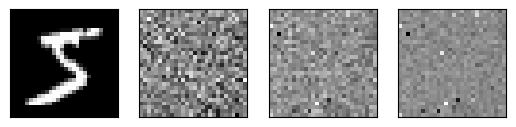

In [45]:
# generate samples from the model
from prior_utils import p_sample_loop
model.eval()
shape = (1, description['num_ambient_dims'])
sample_image = mnist_train[0][0][0]

x_seq = p_sample_loop(model, shape, description['num_steps'], device=device, init_x=None, normalized_beta_schedule=False, schedule='sine')
x_100 = x_seq[0].reshape(28, 28).detach().cpu().numpy()
x_50 = x_seq[49].reshape(28, 28).detach().cpu().numpy()
x_0 = x_seq[99].reshape(28, 28).detach().cpu().numpy()

from image_utils import unscale_to_zero_to_one
x_100 = unscale_to_zero_to_one(x_100)
x_50 = unscale_to_zero_to_one(x_50)
x_0 = unscale_to_zero_to_one(x_0)

print(sample_image.min().item(), sample_image.max().item())
print(x_100.min(), x_100.max())
print(x_50.min(), x_50.max())
print(x_0.min(), x_0.max())

fig, ax = plt.subplots(1,4)
ax[0].imshow(sample_image, cmap='gray')
ax[1].imshow(x_100, cmap='gray')
ax[2].imshow(x_50, cmap='gray')
ax[3].imshow(x_0, cmap='gray')
from utils import remove_all_ticks_and_labels
remove_all_ticks_and_labels(ax)

In [52]:
all_pixels = []
for i in range(100):
    all_pixels.append(mnist_train[i][0].squeeze().reshape(-1))
all_pixels = torch.stack(all_pixels)
print(all_pixels.shape)
all_pixels = rescale_to_neg_one_to_one(all_pixels)
all_pixels = all_pixels.reshape(-1)
print(all_pixels.shape)


print('generating samples from the model')
shape = (100, description['num_ambient_dims'])
x_seq_100s = []
x_seq_50s = []
x_seq_0s = []
x_seq = p_sample_loop(model, shape, description['num_steps'], device=device, init_x=None, normalized_beta_schedule=False, schedule='sine').detach().cpu()
x_seq_100s.append(x_seq[0].reshape(-1))
x_seq_50s.append(x_seq[49].reshape(-1))
x_seq_0s.append(x_seq[-1].reshape(-1))
x_seq_100s = torch.stack(x_seq_100s).squeeze()
x_seq_50s = torch.stack(x_seq_50s).squeeze()
x_seq_0s = torch.stack(x_seq_0s).squeeze()

print(x_seq_100s.shape)


torch.Size([100, 784])
torch.Size([78400])
generating samples from the model
torch.Size([78400])


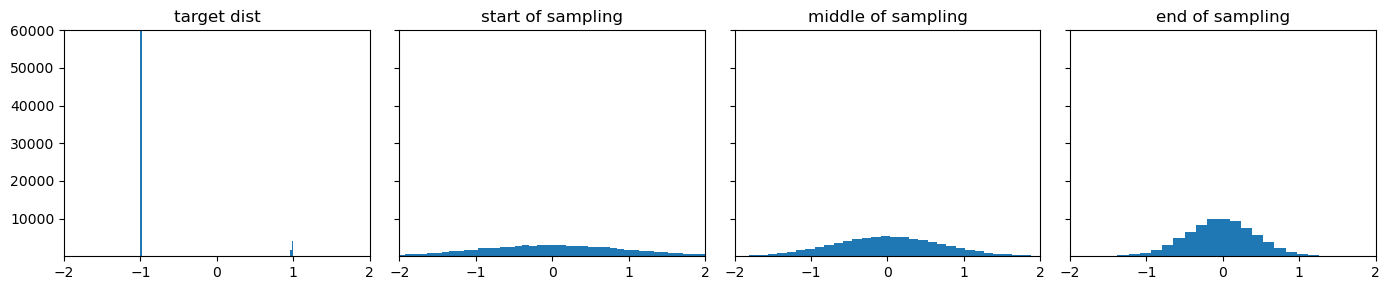

In [64]:
fig, ax = plt.subplots(1,4, figsize=(14, 3), sharey=True, sharex=True)
a = ax[0].hist(all_pixels, bins=100)
ax[0].set(title='target dist')
a = ax[1].hist(x_seq_100s, bins=100)
ax[1].set(title='start of sampling')
a = ax[2].hist(x_seq_50s, bins=100)
ax[2].set(title='middle of sampling')
a = ax[3].hist(x_seq_0s, bins=100)
ax[3].set(title='end of sampling')
for a in ax:
    # a.set_yscale('log')
    a.set_ylim(1e-1, 6e4)
    a.set_xlim(-2, 2)
fig.tight_layout()

torch.Size([100])
tensor(0.0031, dtype=torch.float64)
tensor(0.0025)


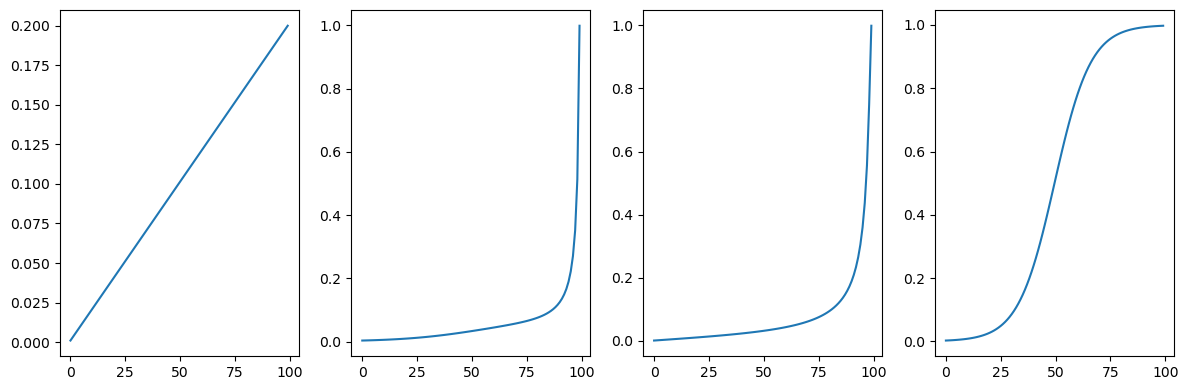

In [49]:
# test new sigmoid beta schedule (that uses images from 0 to 1)
from utils import sigmoid_beta_schedule, cosine_beta_schedule, linear_beta_schedule
betas_linear = linear_beta_schedule(100)
betas_sigmoid = sigmoid_beta_schedule(100)
betas_cos = cosine_beta_schedule(100)
print(betas_sigmoid.shape)

from utils import make_beta_schedule
betas_orig = make_beta_schedule(schedule='sigmoid', n_timesteps=100, start=1e-5, end=1.0)

fig, ax = plt.subplots(1,4, figsize=(12, 4))
ax[0].plot(betas_linear)
ax[1].plot(betas_sigmoid)
ax[2].plot(betas_cos)
ax[3].plot(betas_orig)
fig.tight_layout()

print(betas_sigmoid[0])
print(betas_orig[0])


All the images look the same... maybe it's not taking the time input into consideration at all?? 

Let's check by looking at the weight corresponding to the input. 

In [27]:
model

FullyConnectedNetwork(
  (condlin1): NoiseConditionalLinearConcat(
    (linear): Linear(in_features=785, out_features=1024, bias=True)
  )
  (condlin): NoiseConditionalLinearConcat(
    (linear): Linear(in_features=1025, out_features=1024, bias=True)
  )
  (linear): Linear(in_features=1024, out_features=784, bias=True)
  (nonlin): ReLU()
  (sigmoid): Sigmoid()
  (hidden_layers): MySequential(
    (0): NoiseConditionalLinearConcat(
      (linear): Linear(in_features=1025, out_features=1024, bias=True)
    )
    (1): ReLU()
    (2): NoiseConditionalLinearConcat(
      (linear): Linear(in_features=1025, out_features=1024, bias=True)
    )
    (3): ReLU()
    (4): NoiseConditionalLinearConcat(
      (linear): Linear(in_features=1025, out_features=1024, bias=True)
    )
    (5): ReLU()
    (6): NoiseConditionalLinearConcat(
      (linear): Linear(in_features=1025, out_features=1024, bias=True)
    )
    (7): ReLU()
    (8): NoiseConditionalLinearConcat(
      (linear): Linear(in_features=10

torch.Size([1024, 1025])
tensor([ 0.0012,  0.0096, -0.2217,  ..., -0.0460, -0.0018, -0.1005],
       device='cuda:0', grad_fn=<SelectBackward0>)


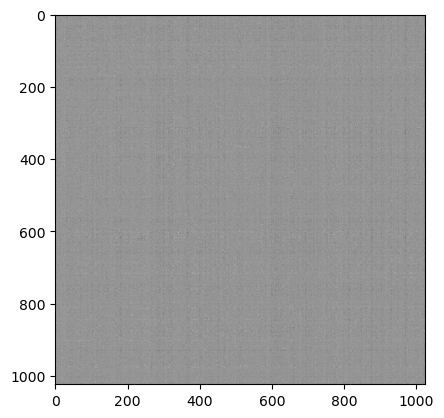

In [35]:
first_linear_weights = model.hidden_layers[0].linear.weight

print(first_linear_weights.shape)

print(first_linear_weights[:, -1])
fig, ax = plt.subplots(1, 1)
ax.imshow(first_linear_weights[:, :].reshape(1024, 1025).detach().cpu().numpy(), cmap='gray')